In [ ]:
!unzip gdrive/MyDrive/datasets/augmented_verified_leaf_dataset.zip

unzip:  cannot find or open gdrive/MyDrive/datasets/augmented_verified_leaf_dataset.zip, gdrive/MyDrive/datasets/augmented_verified_leaf_dataset.zip.zip or gdrive/MyDrive/datasets/augmented_verified_leaf_dataset.zip.ZIP.


In [ ]:
ls

drive/  sample_data/


In [ ]:
%cd drive

/content/drive


In [ ]:
ls


MyDrive/


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as f
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

In [2]:
pip install torchinfo

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class DatasetReader(Dataset):
    def __init__(self, filepath):
        self.X, self.y = torch.load(filepath)
        self.X = self.X/255.0
        self.y = f.one_hot(self.y, num_classes = 2).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [6]:
train_dir = "/content/drive/MyDrive/pytorch_dataset/train"
test_dir = "/content/drive/MyDrive/pytorch_dataset/valid"

In [7]:
train_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
    transforms.Resize((120,120), antialias=True)
])

test_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
    transforms.Resize((120,120,), antialias=True)
])

In [8]:
train_ds = datasets.ImageFolder(train_dir, transform = train_transform)
test_ds = datasets.ImageFolder(test_dir, transform = train_transform)

In [9]:
training_ds, validation_ds = random_split(train_ds,[0.7, 0.3])

In [10]:
batch_size = 2
training_ds = DataLoader(training_ds, batch_size = batch_size, shuffle = True)
validation_ds = DataLoader(validation_ds, batch_size = batch_size, shuffle = True)
testing_ds = DataLoader(test_ds, batch_size = 1, shuffle = True)

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,100, (3, 3), stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(100),
                                    nn.MaxPool2d(kernel_size=(2, 2), stride = 1))

        self.layer2 = nn.Sequential(nn.Conv2d(100, 50, (3, 3), stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(50),
                                    nn.MaxPool2d(kernel_size=(2, 2), stride = 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(50*118*118, 50),
                                        nn.ReLU(),
                                        nn.Linear(50, 10),
                                        nn.ReLU(),
                                        nn.Linear(10, 2))
    def forward(self, X):

        X = self.layer1(X)
        X = self.layer2(X)
        X = self.classifier(X)
        return X


In [12]:
model = NeuralNetwork().to(device)

In [13]:
summary(model)

Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       2,800
│    └─ReLU: 2-2                         --
│    └─BatchNorm2d: 2-3                  200
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       45,050
│    └─ReLU: 2-6                         --
│    └─BatchNorm2d: 2-7                  100
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      34,810,050
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      510
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      22
Total params: 34,858,732
Trainable params: 34,858,732
Non-trainable params: 0

In [14]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train_model(training_ds,model, device):

    """ The function performs use to train the model using training dataset
    and simulataneously use to validate the performance of the model in
    validation dataset. At the end it returns trained model for performing
    further inferencing.
    """

    model.train()
    num_epochs = 5
    for epoch in range(num_epochs):
        train_loss = 0
        correct_train_pred = 0
        for image, label in training_ds:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, label)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_prediction = torch.argmax(output, axis=1)
            correct_train_pred += train_prediction.eq(label).sum().item()

        model.eval()
        val_loss = 0
        correct_val_pred = 0
        batch_counter = 0
        with torch.no_grad():
            for image, label in validation_ds:
                image, label = image.to(device), label.to(device)
                val_output = model(image)
                val_loss += loss_function(val_output, label).item()
                _, prediction = val_output.max(1)
                batch_counter+=label.size(0)
                correct_val_pred+=prediction.eq(label).sum().item()

        avg_training_loss = train_loss / len(training_ds)
        train_accuracy = correct_train_pred/len(training_ds.dataset)
        avg_val_loss = val_loss / len(validation_ds)
        val_accuracy = correct_val_pred/ batch_counter

        print(f"Epoch: [{epoch+1}/{num_epochs}],  Train Loss: {avg_training_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}  ")
    return model

In [16]:
model = train_model(training_ds, model, device)

Epoch: [1/5],  Train Loss: 6.9466, Train Accuracy: 0.6154 Val Loss: 4.6918, Val Accuracy: 0.7000  
Epoch: [2/5],  Train Loss: 0.4502, Train Accuracy: 0.8077 Val Loss: 7.4242, Val Accuracy: 0.8000  
Epoch: [3/5],  Train Loss: 0.2025, Train Accuracy: 0.8077 Val Loss: 9.6664, Val Accuracy: 0.8000  
Epoch: [4/5],  Train Loss: 0.2560, Train Accuracy: 0.8077 Val Loss: 10.6525, Val Accuracy: 0.8000  
Epoch: [5/5],  Train Loss: 0.2633, Train Accuracy: 0.8077 Val Loss: 11.3466, Val Accuracy: 0.8000  


In [17]:
def test_ds_preidiction(model, testing_ds):
    """The function use to run our model in new test dataset and return
    two list that contain actual label and predicted label from the model
    """

    y_pred = []
    y_test = []
    with torch.no_grad():
        for image ,label in testing_ds:
            image, label = image.to(device), label.to(device)
            y_test.append(label.cpu().numpy())
            y_prediction = np.array(model(image).cpu().numpy()).argmax(axis = 1)
            y_pred.append(y_prediction)
        return y_test, y_pred

In [18]:
y_test, y_pred = test_ds_preidiction(model, testing_ds)
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

In [19]:
y_test

array([1, 1, 0, 0, 0, 1, 0, 0, 0])

In [20]:
y_pred

array([0, 0, 1, 1, 1, 1, 1, 1, 1])

In [21]:
print("Accuracy is ", accuracy_score(y_test, y_pred),"\n")
print("Precision is ", precision_score(y_test, y_pred),"\n")
print("Confusion is ", confusion_matrix(y_test, y_pred),"\n")

Accuracy is  0.1111111111111111 

Precision is  0.14285714285714285 

Confusion is  [[0 6]
 [2 1]] 



<ipython-input-22-0acbd040d110>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(resize_img, dtype=torch.float32) / 255.0


The image shows us  Human


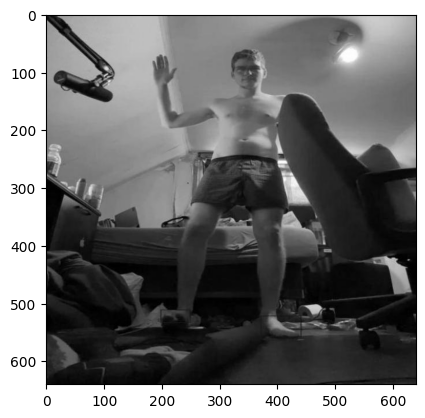

In [22]:
# torch.manaul_seed(42)
label = {0:"Human",1: "Monkey"}
img_path = "/content/drive/MyDrive/pytorch_dataset/train/human/Copy of Copy of standing_8_11_23-3-_jpg.rf.d35d0cd36146daca7ad88c4a8d342970.jpg"
img_array = plt.imread(img_path)
img_tensor = torch.tensor(img_array)
img = img_tensor.permute(2, 0, 1)
resize_img = transforms.Resize((120, 120), antialias=True)
resize_img = resize_img(img)
img_tensor = torch.tensor(resize_img, dtype=torch.float32) / 255.0
reshape_img = img_tensor.unsqueeze(0)
with torch.no_grad():
    output = model(reshape_img.to(device))
ouput = output.cpu().numpy().argmax(1)
print("The image shows us ", label[ouput[0]])
plt.imshow(img_array)
plt.show();

In [24]:
PATH = '/content/drive/MyDrive/pytorch_dataset/model.pt'
torch.save(model.state_dict(), PATH)

In [26]:
model = NeuralNetwork()
model.load_state_dict(torch.load(PATH))
model.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=696200, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [27]:
PATH2 = '/content/drive/MyDrive/pytorch_dataset/entire_model.pt'
torch.save(model, PATH2)

In [29]:
# Model class must be defined somewhere
model = torch.load(PATH2)
model.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=696200, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [31]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/drive/MyDrive/pytorch_dataset/model_scripted.pt') # Save